In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   MultivariateNormalTransition, AdaptivePNormDistance,
                  PNormDistance, History, AdaptivePopulationSize)
from pyabc.visualization import plot_kde_matrix, kde_1d
from pyabc.sampler import DaskDistributedSampler, SingleCoreSampler
from pyabc.transition import LocalTransition
import pyabc.visualization
import logging
import scipy as sp
import scipy.stats as st
import tempfile
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dask.distributed import Client, LocalCluster
import csv


from tools.DataSimulatorControl import simulate

### Setting up the pyabc run

In [2]:
# Initialize the dask cluster 
c = LocalCluster(n_workers=17, threads_per_worker = 2)
client = Client(c,timeout=90)

In [2]:
# Read the study data into a dictionary
control_keys = ["0_4_Adults_mean", "0_5_Adults_mean", "0_6_Adults_mean", "0_7_Adults_mean",
                 "0_4_Adults_sd", "0_5_Adults_sd", "0_6_Adults_sd", "0_7_Adults_sd"]
study_data_path = os.path.abspath('data/data_adults.csv')
reader = csv.reader(open(study_data_path, 'r'))
study_data_all = {}
for row in reader:
   k, v = row
   study_data_all[k] = float(v)
study_data = {key: study_data_all[key] for key in control_keys}
study_data

{'0_4_Adults_mean': 17152.0,
 '0_5_Adults_mean': 19216.0,
 '0_6_Adults_mean': 18229.0,
 '0_7_Adults_mean': 12589.0,
 '0_4_Adults_sd': 3874.0,
 '0_5_Adults_sd': 4729.0,
 '0_6_Adults_sd': 5065.0,
 '0_7_Adults_sd': 4791.0}

In [3]:
# Limits for the plots (accounts for the inverse log transform that pyabc will do with the results)
limits = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3))


priors = dict(ICQueenStrength_mean=(1, 5),
              ICQueenStrength_sd=(0, 2),
              ICForagerLifespan_mean=(4, 16),
              ICForagerLifespan_sd=(0, 3))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in priors.items()})

In [5]:
# Set our distance function and sampler
distance = pyabc.PNormDistance(p=1) #scale type is MAD (more resilient to outliers)
#df_logger = logging.getLogger('DistanceFunction')
#df_logger.setLevel(logging.DEBUG)

#distance = PNormDistance(p=2)

sampler = DaskDistributedSampler(dask_client = client)
#sampler = SingleCoreSampler()

transition = LocalTransition()

In [ ]:
#parameters = {"ICQueenStrength_mean": 1.3, "ICQueenStrength_sd": 1, "ICForagerLifespan_mean": 4, "ICForagerLifespan_sd": 2}
#test = simulate(parameters)

In [ ]:
#test

In [ ]:
# define the ABCSMC object
abc = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(300, max_population_size = 300),
             transitions = transition,
             sampler=sampler)

In [ ]:
# Initialize a new ABC inference run
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "ctrl_only_12_14.db"))
abc.new(db_path, study_data)


INFO:History:Start <ABCSMC(id=1, start_time=2018-12-14 16:45:31.008100, end_time=None)>
INFO:Epsilon:initial epsilon is 66738.1815638901


1

In [10]:
history = abc.run(max_nr_populations=25, minimum_epsilon=0)

NameError: name 'abc' is not defined

In [5]:
pop_data = history.get_all_populations()
pop_data

,t,population_end_time,samples,epsilon,particles
0,-1,2018-12-14 16:45:33.778587,0,0.000000,1
1,0,2018-12-14 20:07:46.566566,720,66738.181564,300
2,1,2018-12-14 22:13:07.173171,670,46699.063582,300
3,2,2018-12-15 00:47:19.497222,745,37772.938209,300
4,3,2018-12-15 03:27:31.261328,808,34133.046494,300
5,4,2018-12-17 20:18:47.300351,1221,31944.615160,300
6,5,2018-12-18 01:18:32.297278,1819,30395.138046,300
7,6,2018-12-18 09:16:38.962583,2928,29408.617696,300
8,7,2018-12-19 08:26:03.234803,5604,28532.789089,300


In [6]:
#get acceptance rates for each generation
print("Acceptance rates")
for gen, samples, particles in zip(pop_data['t'],pop_data['samples'], pop_data['particles']):
    if(samples>0):
        print("Gen {}: {:.1f}%".format(gen+1,particles/samples*100))

Acceptance rates
Gen 1: 41.7%
Gen 2: 44.8%
Gen 3: 40.3%
Gen 4: 37.1%
Gen 5: 24.6%
Gen 6: 16.5%
Gen 7: 10.2%
Gen 8: 5.4%


In [13]:
history.total_nr_simulations

2943

### Visualize results

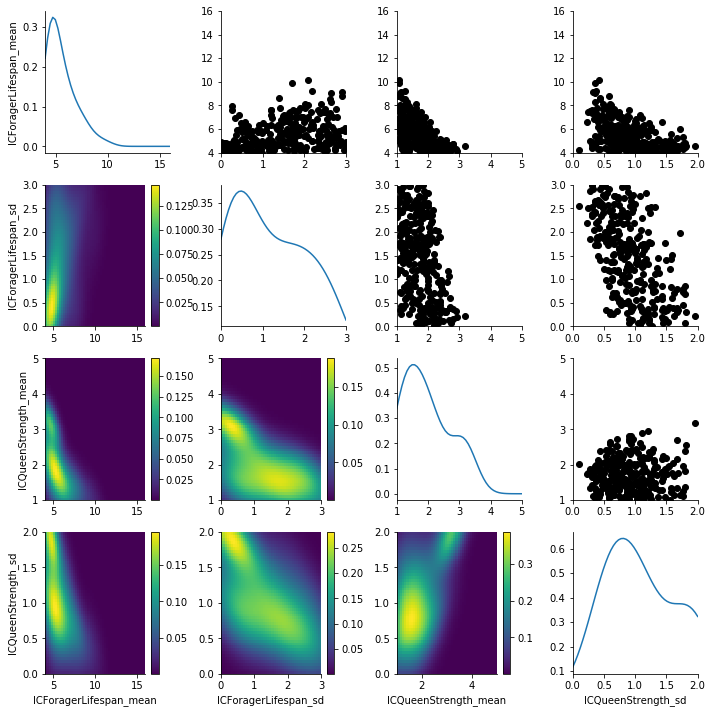

In [13]:
df, w = history.get_distribution(m=0, t=7)
plot_kde_matrix(df, w, limits=limits);

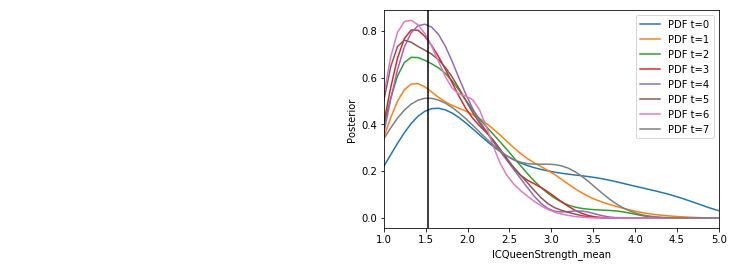

In [8]:
variable = 'ICQueenStrength_mean'
fig, ax = plt.subplots()
for t in range(history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=1, xmax=5,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
plt.axvline(x=MAP.item(),color='black')
ax.legend()
ax.annotate('Max: {:.2f} ng/bee'.format(10**MAP.item()*1000), xy = (-3.5,0.75))
plt.show()

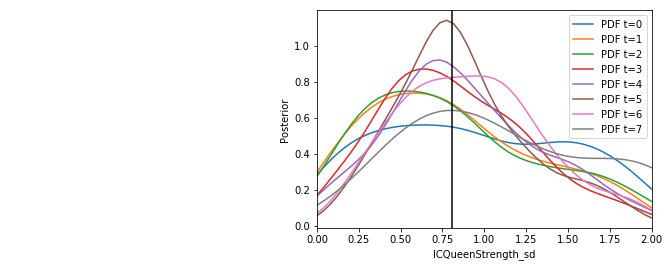

In [9]:
variable = 'ICQueenStrength_sd'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=2,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
ax.legend()
plt.axvline(x=MAP.item(),color='black')
ax.annotate('Max: {:.2f} ng/bee'.format(10**MAP.item()*1000), xy = (-1.85,0.65))
plt.show()

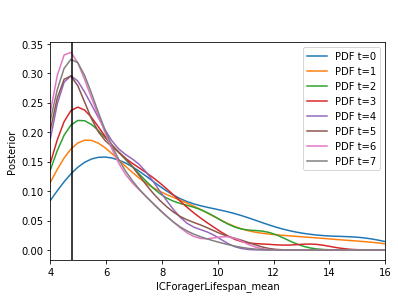

In [10]:
variable = 'ICForagerLifespan_mean'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=4, xmax=16,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
ax.legend()
plt.axvline(x=MAP.item(),color='black')
ax.annotate('Max: {:.2f} days'.format(MAP.item()), xy = (5.5,0.4))
ax.legend()
plt.show()

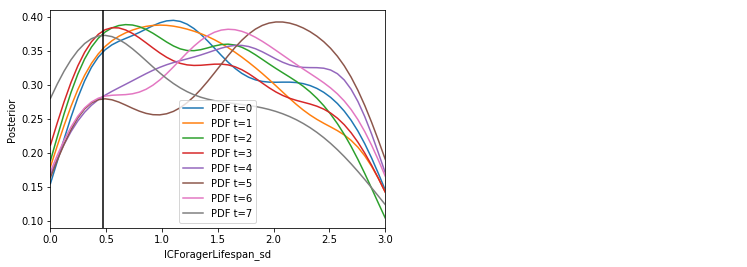

In [11]:
variable = 'ICForagerLifespan_sd'
fig, ax = plt.subplots()
for t in range(0,history.max_t + 1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=3,
                                   x=variable, ax=ax,
                                   label="PDF t={}".format(t))
x, pdf = kde_1d(df,w,variable, numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
ax.legend()
plt.axvline(x=MAP.item(),color='black')
ax.annotate('Max: {:.2f} days'.format(MAP.item()), xy = (5.5,0.4))
ax.legend()
plt.show()

### Visualize from a stored run

In [4]:
#retrieve stored run - run ID 1
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "ctrl_only_12_14.db"))
history = History(db_path)
history.id = 1

In [6]:
history

In [12]:
df, w = history.get_distribution(m=0, t=7)

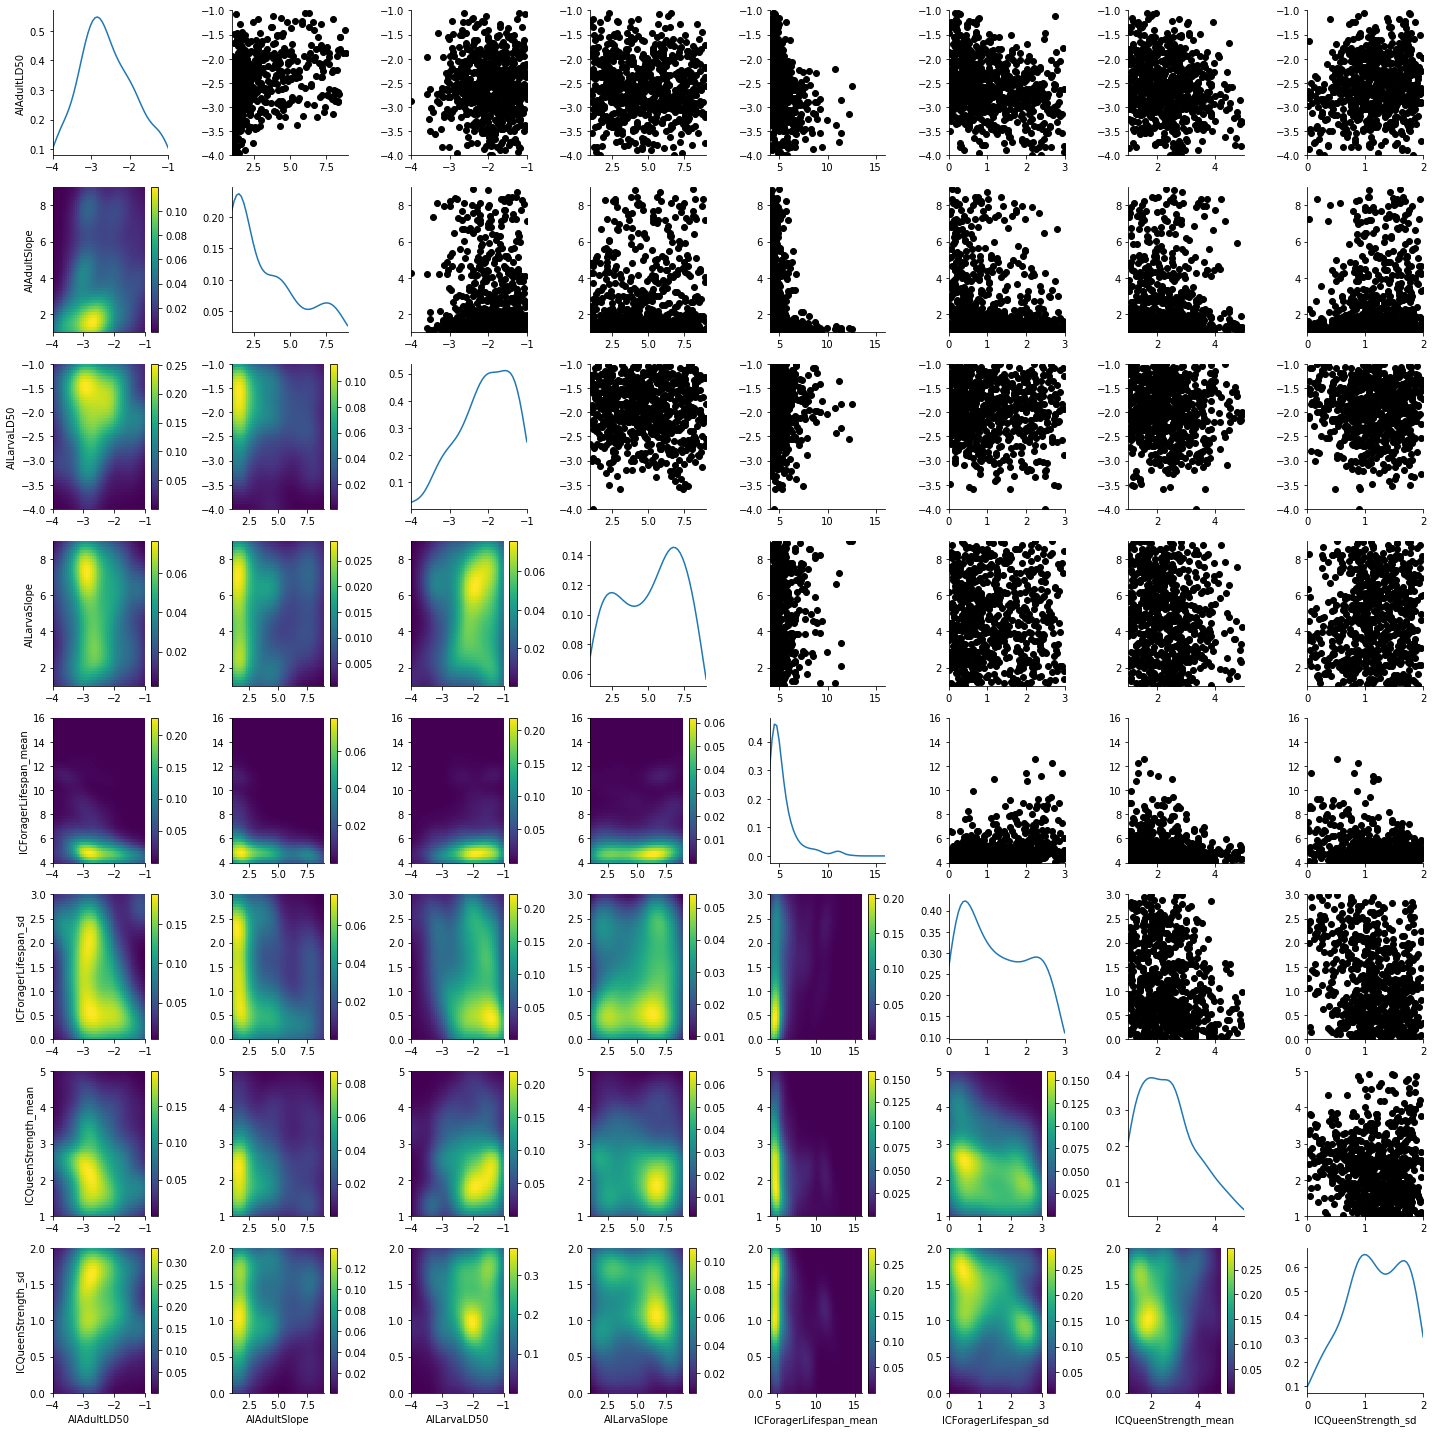

In [13]:
plot_kde_matrix(df, w, limits=limits);

In [45]:
df

name,AIAdultLD50,AIAdultSlope,AILarvaLD50,AILarvaSlope,ICForagerLifespan_mean,ICForagerLifespan_sd,ICQueenStrength_mean,ICQueenStrength_sd
id,,,,,,,,
303,-2.685636,8.094345,-1.772840,5.406513,14.553191,0.657079,3.449022,1.267300
304,-2.663545,6.648187,-1.451895,5.516439,13.541263,1.298367,4.598010,1.923057
305,-2.829690,5.112503,-1.767447,7.463796,13.834600,0.846625,4.239668,1.554032
306,-2.582455,7.101485,-2.014743,4.465162,14.222965,0.471162,3.354573,1.982290
307,-2.842316,7.089738,-2.690495,4.839774,15.594149,0.451034,4.609429,1.665724
308,-2.635456,7.884031,-1.836026,7.646172,13.272350,1.156771,1.976554,0.801624
309,-2.508028,8.440665,-2.146109,3.999631,14.399742,1.306812,3.333596,1.412176
310,-2.841345,6.523990,-1.562820,5.604397,14.675542,0.643028,2.680901,1.041421
311,-2.798456,7.773063,-2.223311,4.389313,14.535816,0.919606,3.942047,1.605260


In [7]:
history.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2018-11-21 13:00:49.506982,0,0.000000,1
1,0,2018-11-22 03:23:25.736873,1050,45093.710464,500
2,1,2018-11-22 20:29:59.210061,1852,43829.242970,700
3,2,2018-11-23 20:26:20.513080,2597,42429.560910,700
4,3,2018-11-25 13:45:38.166100,3575,41384.001976,700
5,4,2018-11-27 05:17:31.478573,4416,41349.192336,700
6,5,2018-11-28 19:39:04.627983,4426,41368.095419,700
7,6,2018-12-02 11:57:03.569684,3882,44891.364807,700
8,7,2018-12-04 07:18:16.336575,4710,43520.700319,700
9,8,2018-12-05 21:40:29.710463,2941,42327.206485,700


In [14]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-20 16:41:20.170554, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-11-20 16:50:58.666070, end_time=2018-11-21 05:07:04.583930)>,
 <ABCSMC(id=3, start_time=2018-11-21 13:00:46.200087, end_time=None)>]

In [14]:
#get the maximum a posteriori estimation for ICQueenStrength_mean
x, pdf = kde_1d(df,w,"ICQueenStrength_mean", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
adult_qs_map = MAP.item() #un-log transformed and converted to ng/bee

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"ICQueenStrength_mean", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
adult_qs_median = x.item(np.min(np.where(cdf > .5))) #un-log transformed and converted to ng/bee
print('Mean queen strength MAP: {:.2f}, median: {:.2f}'.format(adult_qs_map, adult_qs_median))

# calculate 95% credible interval
adult_qs_mean_lower = x.item(np.min(np.where(cdf > .025)))
adult_qs_mean_upper = x.item(np.min(np.where(cdf > .975)))
print("95% CI: {} - {}".format(adult_qs_mean_lower, adult_qs_mean_upper))

mean Queen STrength MAP: 1.30, median: 1.60
95% CI: 1.0326441960321153 - 2.6774489467972904


In [16]:
#get the maximum a posteriori estimation for ICForagerLifespan_mean
x, pdf = kde_1d(df,w,"ICForagerLifespan_mean", numx = 200)
MAP = x[np.where(np.max(pdf)==pdf)]
adult_fl_map = MAP.item() #un-log transformed and converted to ng/bee

#calculate the median by converting our pdf (actually pmf) to a cdf
x, pdf = kde_1d(df,w,"ICForagerLifespan_mean", numx = 200)
cdf = np.cumsum(pdf) / np.sum(pdf)
adult_fl_median = x.item(np.min(np.where(cdf > .5))) #un-log transformed and converted to ng/bee
print('Mean forager lifespan MAP: {:.2f}, median: {:.2f}'.format(adult_fl_map, adult_fl_median))

# calculate 95% credible interval
adult_fl_mean_lower = x.item(np.min(np.where(cdf > .025)))
adult_fl_mean_upper = x.item(np.min(np.where(cdf > .975)))
print("95% CI: {} - {}".format(adult_fl_mean_lower, adult_fl_mean_upper))

Mean forager lifespan MAP: 4.66, median: 5.44
95% CI: 4.074807724086581 - 9.455279671323652


### Continuing a stopped run

In [6]:
#retrieve stored run 
database_dir = 'results_db/'
db_path = ("sqlite:///" +
           os.path.join(database_dir, "ctrl_only_12_14.db"))
#db = History(db_path)
#db.id = 3

In [7]:
# define the ABCSMC object
abc_cont = ABCSMC(simulate, prior, distance,
             population_size=AdaptivePopulationSize(300, max_population_size = 300),
             transitions = transition,
             sampler=sampler)

In [8]:
abc_cont.load(db_path,1)

INFO:Epsilon:initial epsilon is 28532.789088791316


1

In [9]:
abc_cont.run(minimum_epsilon=0, max_nr_populations=20)

INFO:ABC:t:7 eps:28532.789088791316
INFO:Adaptation:Change nr particles 300 -> 300
INFO:ABC:t:8 eps:27708.38570620799
INFO:Adaptation:Change nr particles 300 -> 300


KeyboardInterrupt: 